# Big-Five Factor Markers

In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Data Overview

## DataLoad

In [2]:
df = pd.read_csv('dataset/BigFivePersonalityTest-TrainSet.csv', parse_dates = ['dateload'])
df.rename(columns={'Unnamed: 0':'id'},inplace = True)
pd.options.display.float_format = "{:,.2f}".format
pd.options.display.max_columns = 999
df.head()

,id,EXT1,EXT2,EXT3,EXT4,EXT5,EXT6,EXT7,EXT8,EXT9,EXT10,EST1,EST2,EST3,EST4,EST5,EST6,EST7,EST8,EST9,EST10,AGR1,AGR2,AGR3,AGR4,AGR5,AGR6,AGR7,AGR8,AGR9,AGR10,CSN1,CSN2,CSN3,CSN4,CSN5,CSN6,CSN7,CSN8,CSN9,CSN10,OPN1,OPN2,OPN3,OPN4,OPN5,OPN6,OPN7,OPN8,OPN9,OPN10,EXT1_E,EXT2_E,EXT3_E,EXT4_E,EXT5_E,EXT6_E,EXT7_E,EXT8_E,EXT9_E,EXT10_E,EST1_E,EST2_E,EST3_E,EST4_E,EST5_E,EST6_E,EST7_E,EST8_E,EST9_E,EST10_E,AGR1_E,AGR2_E,AGR3_E,AGR4_E,AGR5_E,AGR6_E,AGR7_E,AGR8_E,AGR9_E,AGR10_E,CSN1_E,CSN2_E,CSN3_E,CSN4_E,CSN5_E,CSN6_E,CSN7_E,CSN8_E,CSN9_E,CSN10_E,OPN1_E,OPN2_E,OPN3_E,OPN4_E,OPN5_E,OPN6_E,OPN7_E,OPN8_E,OPN9_E,OPN10_E,dateload,screenw,screenh,introelapse,testelapse,endelapse,IPC,country,lat_appx_lots_of_err,long_appx_lots_of_err,target
0,441310,3.00,3.00,3.00,3.00,4.00,4.00,3.00,4.00,3.00,4.00,3.00,3.00,4.00,3.00,4.00,4.00,4.00,3.00,4.00,4.00,4.00,4.00,4.00,4.00,3.00,5.00,0.00,4.00,4.00,4.00,3.00,3.00,3.00,3.00,4.00,3.00,4.00,3.00,4.00,3.00,2.00,3.00,4.00,3.00,4.00,1.00,4.00,3.00,4.00,3.00,"6,462.00","2,273.00","1,625.00","4,960.00","6,040.00","3,983.00","3,608.00","3,376.00","3,216.00","4,544.00","2,913.00","13,480.00","3,008.00","3,496.00","4,640.00","2,274.00","2,080.00","2,535.00","2,545.00","1,719.00","5,432.00","4,696.00","2,319.00","1,944.00","5,008.00","2,698.00",0.00,"23,048.00","2,040.00","3,608.00","2,528.00","4,008.00","2,361.00","2,528.00","2,760.00","7,662.00","4,736.00","2,697.00","2,095.00","1,704.00","2,958.00","2,471.00","2,184.00","1,880.00","3,024.00","2,375.00","2,456.00","1,840.00","2,016.00","2,232.00",2017-06-25 19:21:21,"1,920.00","1,080.00",7.00,186.00,21,1,US,35.057,-79.0147,C
1,985842,3.00,4.00,4.00,3.00,2.00,3.00,5.00,2.00,4.00,4.00,3.00,4.00,4.00,1.00,2.00,2.00,4.00,4.00,4.00,4.00,2.00,4.00,2.00,4.00,2.00,4.00,2.00,4.00,4.00,5.00,3.00,3.00,3.00,2.00,2.00,4.00,3.00,3.00,3.00,2.00,4.00,1.00,5.00,1.00,4.00,1.00,5.00,4.00,4.00,5.00,"35,691.00","2,218.00","1,492.00","1,685.00","2,667.00","1,757.00","3,513.00",906.00,"1,211.00","2,013.00","1,401.00","2,884.00","1,100.00","1,276.00","1,416.00","5,026.00","1,142.00","1,518.00","1,761.00","2,382.00","1,426.00",995.00,"1,873.00","1,705.00","1,259.00","1,215.00","1,607.00","2,478.00","1,115.00","1,064.00","1,618.00","2,390.00","1,139.00","1,925.00","1,356.00","3,875.00","1,291.00","2,916.00","1,315.00","2,181.00","1,122.00",834.00,"2,201.00","10,365.00","1,283.00","1,490.00","2,185.00","1,318.00","1,227.00","1,247.00",2018-10-24 08:10:07,"1,366.00",768.00,15.00,133.00,7,14,SG,1.2931,103.8558,N
2,628988,3.00,3.00,2.00,3.00,2.00,3.00,1.00,2.00,2.00,5.00,2.00,4.00,2.00,1.00,4.00,3.00,2.00,3.00,4.00,4.00,3.00,4.00,1.00,2.00,4.00,4.00,2.00,2.00,4.00,3.00,2.00,2.00,2.00,4.00,1.00,4.00,4.00,4.00,0.00,2.00,2.00,2.00,5.00,1.00,3.00,2.00,3.00,3.00,4.00,4.00,"30,932.00","2,514.00","4,927.00","8,252.00","7,885.00","3,500.00","3,973.00","1,231.00","1,117.00","1,309.00",985.00,926.00,"1,133.00","5,290.00","33,489.00","3,101.00","2,600.00","12,058.00","6,068.00",684.00,"13,743.00","1,823.00","2,268.00","2,891.00","4,402.00","4,891.00","6,840.00","2,899.00","11,554.00","2,416.00","2,498.00","3,435.00","11,042.00","12,779.00","1,510.00","4,093.00","4,769.00","12,279.00",0.00,"9,355.00","4,027.00","4,616.00","1,974.00","2,000.00","3,203.00","4,126.00","2,514.00","4,169.00","1,800.00","5,787.00",2018-02-26 18:56:06,"1,680.00","1,050.00",3.00,286.00,16,11,HK,22.25,114.1667,N
3,704960,3.00,3.00,2.00,3.00,3.00,4.00,1.00,3.00,4.00,5.00,4.00,2.00,5.00,3.00,2.00,4.00,4.00,3.00,4.00,3.00,4.00,3.00,4.00,4.00,2.00,5.00,2.00,3.00,4.00,5.00,3.00,5.00,5.00,3.00,2.00,4.00,1.00,2.00,5.00,3.00,3.00,4.00,3.00,3.00,3.00,2.00,3.00,3.00,5.00,3.00,"8,624.00","2,872.00","5,600.00","3,152.00","5,775.00","1,753.00","4,208.00","5,648.00","7,136.00","1,704.00","2,361.00","7,576.00","2,360.00","5,584.00","3,328.00","2,728.00","2,567.00","2,880.00","1,120.00","4,376.00","3,113.00","1,681.00","2,400.00","3,415.00","3,921.00","3,120.00","4,672.00","4,344.00","4,064.00","3,457.00","3,071.00","2,920.00","2,792.00","1,9

In [3]:
print(f'Train dataset has {df.shape[0]} rows and {df.shape[1]} features.')
df.describe()

Train dataset has 964573 rows and 112 features.


,id,EXT1,EXT2,EXT3,EXT4,EXT5,EXT6,EXT7,EXT8,EXT9,EXT10,EST1,EST2,EST3,EST4,EST5,EST6,EST7,EST8,EST9,EST10,AGR1,AGR2,AGR3,AGR4,AGR5,AGR6,AGR7,AGR8,AGR9,AGR10,CSN1,CSN2,CSN3,CSN4,CSN5,CSN6,CSN7,CSN8,CSN9,CSN10,OPN1,OPN2,OPN3,OPN4,OPN5,OPN6,OPN7,OPN8,OPN9,OPN10,EXT1_E,EXT2_E,EXT3_E,EXT4_E,EXT5_E,EXT6_E,EXT7_E,EXT8_E,EXT9_E,EXT10_E,EST1_E,EST2_E,EST3_E,EST4_E,EST5_E,EST6_E,EST7_E,EST8_E,EST9_E,EST10_E,AGR1_E,AGR2_E,AGR3_E,AGR4_E,AGR5_E,AGR6_E,AGR7_E,AGR8_E,AGR9_E,AGR10_E,CSN1_E,CSN2_E,CSN3_E,CSN4_E,CSN5_E,CSN6_E,CSN7_E,CSN8_E,CSN9_E,CSN10_E,OPN1_E,OPN2_E,OPN3_E,OPN4_E,OPN5_E,OPN6_E,OPN7_E,OPN8_E,OPN9_E,OPN10_E,screenw,screenh,introelapse,testelapse,endelapse,IPC
count,"964,573.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,611.00","962,611.00","962,611.00","962,863.00","964,573.00","964,573.00"
mean,"507,687.98",2.65,2.77,3.29,3.14,3.28,2.40,2.77,3.41,2.96,3.56,3.29,3.16,3.85,2.66,2.84,2.84,3.05,2.68,3.09,2.77,2.26,3.83,2.26,3.93,2.27,3.74,2.20,3.69,3.79,3.59,3.30,2.93,3.98,2.62,2.63,2.83,3.70,2.47,3.20,3.59,3.65,2.08,4.00,2.00,3.79,1.89,3.98,3.18,4.12,3.96,"98,303.87","7,868.34","11,745.72","7,488.71","7,204.35","7,520.52","11,095.22","7,097.06","6,189.12","7,556.75","9,611.44","9,304.36","7,805.62","10,855.95","10,405.29","8,276.98","6,979.06","8,080.31","5,464.28","4,760.57","18,399.51","8,656.28","6,649.63","9,090.83","11,311.82","6,211.18","8,382.48","9,099.23","5,352.74","6,098.79","12,310.78","10,173.74","8,854.18","9,184.09","9,131.43","11,617.35","5,615.05","10,904.71","5,500.40","11,005.06","8,574.32","13,270.75","7,135.83","13,599.00","6,264.19","8,307.59","7,780.77","5,470.92","6,385.60","5,428.93","1,149.46",826.32,957.42,660.47,"2,777.03",10.45
std,"293,090.74",1.26,1.32,1.22,1.24,1.28,1.23,1.40,1.27,1.35,1.31,1.35,1.23,1.16,1.25,1.27,1.33,1.29,1.34,1.30,1.32,1.34,1.14,1.28,1.13,1.17,1.22,1.12,1.10,1.17,1.08,1.18,1.39,1.04,1.25,1.27,1.42,1.13,1.14,1.28,1.05,1.16,1.11,1.10,1.09,0.99,1.10,1.01,1.26,1.04,1.03,"4,992,401.50","441,714.70","2,386,077.66","326,273.72","616,676.97","580,364.77","2,246,859.43","377,293.00","254,007.57","2,200,702.23","1,273,595.26","638,532.79","726,467.68","1,131,015.40","2,235,275.74","719,566.43","398,919.06","2,210,038.56","449,060.97","174,032.90","1,772,232.70","722,187.36","263,899.03","773,434.95","2,235,320.93","343,937.00","684,252.94","1,436,147.22","163,695.04","312,378.39","1,335,930.00","576,368.51","1,246,966.57","731,616.04","1,040,988.90","2,291,148.64","275,729.19","513,744.64","414,599.49","2,262,755.84","955,851.49","1,253,111.74","372,066.85","3,126,721.52","343,716.77","574,789.43","598,264.56","269,737.77","440,852.68","452,223.85",560.05,180.26,"51,912.03","15,824.76","1,522,388.82",39.79
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00

## Missing Values

In [4]:
df.drop(labels= ['id'],axis=1,inplace = True)
df.replace(to_replace = 0, value = np.nan,inplace = True)
df.isnull().sum()[df.isnull().sum()>0].to_frame('Nulls').sort_values(by = 'Nulls')/len(df)*100

,Nulls
country,0.01
target,0.18
testelapse,0.18
introelapse,0.21
screenh,0.47
...,...
AGR6_E,1.62
EST2_E,1.63
EST6_E,1.67
EST4_E,1.68


In [5]:
df.dropna(axis = 0,inplace = True)

,EXT1,EXT2,EXT3,EXT4,EXT5,EXT6,EXT7,EXT8,EXT9,EXT10,EST1,EST2,EST3,EST4,EST5,EST6,EST7,EST8,EST9,EST10,AGR1,AGR2,AGR3,AGR4,AGR5,AGR6,AGR7,AGR8,AGR9,AGR10,CSN1,CSN2,CSN3,CSN4,CSN5,CSN6,CSN7,CSN8,CSN9,CSN10,OPN1,OPN2,OPN3,OPN4,OPN5,OPN6,OPN7,OPN8,OPN9,OPN10,EXT1_E,EXT2_E,EXT3_E,EXT4_E,EXT5_E,EXT6_E,EXT7_E,EXT8_E,EXT9_E,EXT10_E,EST1_E,EST2_E,EST3_E,EST4_E,EST5_E,EST6_E,EST7_E,EST8_E,EST9_E,EST10_E,AGR1_E,AGR2_E,AGR3_E,AGR4_E,AGR5_E,AGR6_E,AGR7_E,AGR8_E,AGR9_E,AGR10_E,CSN1_E,CSN2_E,CSN3_E,CSN4_E,CSN5_E,CSN6_E,CSN7_E,CSN8_E,CSN9_E,CSN10_E,OPN1_E,OPN2_E,OPN3_E,OPN4_E,OPN5_E,OPN6_E,OPN7_E,OPN8_E,OPN9_E,OPN10_E,screenw,screenh,introelapse,testelapse,endelapse,IPC
count,"822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00"
mean,2.65,2.79,3.30,3.17,3.30,2.41,2.78,3.44,2.98,3.59,3.31,3.20,3.87,2.69,2.85,2.87,3.06,2.69,3.10,2.79,2.25,3.87,2.27,3.96,2.28,3.78,2.21,3.72,3.81,3.62,3.34,2.95,4.00,2.63,2.63,2.84,3.73,2.48,3.22,3.63,3.70,2.07,4.04,2.00,3.82,1.90,4.02,3.22,4.17,3.98,"98,602.42","7,734.03","9,173.65","7,268.56","7,369.92","6,420.79","7,998.01","6,917.67","5,827.72","7,907.50","9,768.94","8,754.54","7,333.72","10,490.27","10,313.27","8,607.30","6,606.76","5,551.48","5,531.29","4,393.09","17,698.29","8,168.13","6,555.48","8,943.96","8,348.91","5,844.08","8,456.67","9,507.03","5,293.16","6,156.80","12,181.32","9,487.33","8,245.43","8,620.66","9,370.12","9,384.51","5,344.65","10,683.62","5,584.26","11,171.21","8,530.49","13,514.97","6,993.92","11,369.36","5,929.34","8,153.41","7,614.15","5,211.86","6,277.63","4,466.62","1,144.12",827.60,980.96,624.92,"3,095.41",10.00
std,1.25,1.31,1.19,1.21,1.24,1.21,1.38,1.24,1.32,1.27,1.32,1.19,1.13,1.23,1.25,1.30,1.27,1.32,1.27,1.31,1.32,1.08,1.27,1.08,1.15,1.16,1.10,1.04,1.13,1.03,1.12,1.37,1.00,1.23,1.25,1.40,1.08,1.12,1.25,1.00,1.10,1.09,1.04,1.07,0.93,1.08,0.94,1.22,0.97,0.99,"5,266,494.18","449,037.30","960,976.31","274,375.95","658,714.38","352,873.92","276,896.35","344,433.42","159,031.07","2,379,545.08","1,367,126.46","604,868.19","518,772.10","1,184,031.97","2,396,266.84","774,109.44","340,298.33","168,967.98","481,418.90","101,625.89","1,806,339.75","563,476.74","269,692.35","741,125.89","371,867.11","289,162.77","728,743.06","1,552,793.92","160,469.33","333,100.87","1,328,767.08","451,571.38","1,260,977.26","590,388.80","1,122,628.31","721,942.63","243,331.27","467,664.44","443,801.57","2,432,900.28","1,014,975.34","1,335,055.02","370,462.23","2,404,735.88","305,184.91","560,296.22","602,421.82","231,623.26","459,634.21","247,235.99",560.82,175.61,"55,225.31","16,359.77","1,648,074.31",37.93
min,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 822925 entries, 1 to 964572
Columns: 111 entries, EXT1 to target
dtypes: datetime64[ns](1), float64(104), int64(2), object(4)
memory usage: 743.2+ MB


## Balance Of Target Variable

`Extroversion (E)`: Altos puntajes tienden a ser personas muy sociables, mientras que bajos puntajes prefieren trabajar solos en proyectos.  
`Agreeableness (A)`: Altos puntajes tienen a ser personas con comportamiento políticamente correcto, mientras que bajos puntajes tienden a ser personas muy directas.  
`Conscientiouness (C)`: Altos puntajes tienen a ser personas que siguen las reglas y prefieren el orden, mientras que bajos puntajes tienden a ser personas desordenadas.  
`Neuroticism (N)`: El nivel “ser emocional” de una persona.  
`Openness to Experience (O)`: Altos puntajes tienden a ser personas que “sueñan despiertas”, mientras que bajos puntajes tienden a “estar con los pies sobre la tierra”.

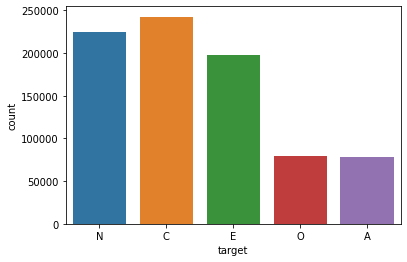

In [6]:
sns.countplot('target',data = df)

## Data Transformation
- Conversion of milliseconds to minutes  
- Drop of outliers using IQR

In [7]:
df_columns = df.columns
time_columns = []

for col in df_columns:
    if '_E' in str(col):
        time_columns.append(col)
        df[col] = df[col].apply(lambda x: abs(x/1000/60))
        q1 = df[col].quantile(0.25)
        q2 = df[col].quantile(0.50)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        df[col] = df[col].apply(lambda x: q2 if (x>=q3 + 1.5*iqr) else x)

In [8]:
df.describe()

,EXT1,EXT2,EXT3,EXT4,EXT5,EXT6,EXT7,EXT8,EXT9,EXT10,EST1,EST2,EST3,EST4,EST5,EST6,EST7,EST8,EST9,EST10,AGR1,AGR2,AGR3,AGR4,AGR5,AGR6,AGR7,AGR8,AGR9,AGR10,CSN1,CSN2,CSN3,CSN4,CSN5,CSN6,CSN7,CSN8,CSN9,CSN10,OPN1,OPN2,OPN3,OPN4,OPN5,OPN6,OPN7,OPN8,OPN9,OPN10,EXT1_E,EXT2_E,EXT3_E,EXT4_E,EXT5_E,EXT6_E,EXT7_E,EXT8_E,EXT9_E,EXT10_E,EST1_E,EST2_E,EST3_E,EST4_E,EST5_E,EST6_E,EST7_E,EST8_E,EST9_E,EST10_E,AGR1_E,AGR2_E,AGR3_E,AGR4_E,AGR5_E,AGR6_E,AGR7_E,AGR8_E,AGR9_E,AGR10_E,CSN1_E,CSN2_E,CSN3_E,CSN4_E,CSN5_E,CSN6_E,CSN7_E,CSN8_E,CSN9_E,CSN10_E,OPN1_E,OPN2_E,OPN3_E,OPN4_E,OPN5_E,OPN6_E,OPN7_E,OPN8_E,OPN9_E,OPN10_E,screenw,screenh,introelapse,testelapse,endelapse,IPC
count,"822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00"
mean,2.65,2.79,3.30,3.17,3.30,2.41,2.78,3.44,2.98,3.59,3.31,3.20,3.87,2.69,2.85,2.87,3.06,2.69,3.10,2.79,2.25,3.87,2.27,3.96,2.28,3.78,2.21,3.72,3.81,3.62,3.34,2.95,4.00,2.63,2.63,2.84,3.73,2.48,3.22,3.63,3.70,2.07,4.04,2.00,3.82,1.90,4.02,3.22,4.17,3.98,0.13,0.06,0.06,0.06,0.05,0.05,0.08,0.06,0.06,0.06,0.06,0.06,0.05,0.06,0.06,0.06,0.06,0.05,0.05,0.05,0.08,0.06,0.06,0.06,0.07,0.05,0.06,0.07,0.06,0.06,0.06,0.07,0.06,0.06,0.06,0.08,0.05,0.07,0.05,0.07,0.05,0.07,0.05,0.07,0.05,0.06,0.06,0.05,0.06,0.04,"1,144.12",827.60,980.96,624.92,"3,095.41",10.00
std,1.25,1.31,1.19,1.21,1.24,1.21,1.38,1.24,1.32,1.27,1.32,1.19,1.13,1.23,1.25,1.30,1.27,1.32,1.27,1.31,1.32,1.08,1.27,1.08,1.15,1.16,1.10,1.04,1.13,1.03,1.12,1.37,1.00,1.23,1.25,1.40,1.08,1.12,1.25,1.00,1.10,1.09,1.04,1.07,0.93,1.08,0.94,1.22,0.97,0.99,0.07,0.03,0.03,0.03,0.02,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.02,0.03,0.03,0.03,0.03,0.02,0.02,0.02,0.04,0.03,0.03,0.03,0.03,0.02,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.02,0.04,0.02,0.03,0.03,0.03,0.02,0.03,0.02,0.03,0.03,0.02,0.03,0.02,560.82,175.61,"55,225.31","16,359.77","1,648,074.31",37.93
min,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00
25%,2.00,2.00,2.00,2.00,2.00,1.00,2.00,2.00,2.00,3.00,2.00,2.00,3.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,1.00,3.00,1.00,3.00,1.00,3.00,1.00,3.00,3.00,3.00,3.00,2.00,3.00,2.00,2.00,2.00,3.00,2.00,2.00,3.00,3.00,1.00,3.00,1.00,3.00,1.00,4.00,2.00,4.00,3.00,0.08,0.04,0.04,0.04,0.04,0.04,0.05,0.04,0.04,0.

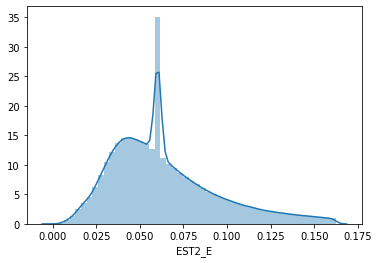

In [16]:
sns.distplot(df['EST2_E'])